# Attack a saved target model via reference models or distilled models

## Imports

In [4]:
logdir = "exp/cifar10_wrn28-2_16_reference"

import numpy as np
import tensorflow as tf

For now we install the Privacy Meter library from the local source. A version will be pushed to pip soon.

In [5]:
from privacy_meter.audit import Audit, MetricEnum
from privacy_meter.audit_report import ROCCurveReport, SignalHistogramReport
from privacy_meter.constants import InferenceGame
from privacy_meter.dataset import Dataset
from privacy_meter.information_source import InformationSource
from privacy_meter.model import TensorflowModel
import privacy_meter.hypothesis_test as prtest
from privacy_meter.metric import ReferenceMetric
from privacy_meter.information_source_signal import ModelLoss

## Settings

Setting seed for reproducibility:

In [6]:
seed = 1234
np.random.seed(seed)
rng = np.random.default_rng(seed=seed)
tf.compat.v1.set_random_seed(seed)

Hyperparameters:

In [7]:
# for training the dummy models
num_points_per_train_split = 5000
num_points_per_test_split = 1000
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optim_fn = 'adam'
epochs = 1
batch_size = 64
regularizer_penalty = 0.01
regularizer = tf.keras.regularizers.l2(l=regularizer_penalty)

In [8]:
# for the dummy reference metric
num_reference_models = 1
fpr_tolerance_list = list(np.logspace(-5,0,100))

## Dataset creation

We use the CIFAR100 dataset for this tutorial. As Tensorflow already has the data loading code for CIFAR100, we just need to add our pre-processing code on top of it.

In [9]:
def preprocess_cifar100_dataset():
    input_shape, num_classes = (32, 32, 3), 100

    # split the data between train and test sets
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

    # scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255

    # convert labels into one hot vectors
    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)

    return x_train, y_train, x_test, y_test, input_shape, num_classes

x_train_all, y_train_all, x_test_all, y_test_all, input_shape, num_classes = preprocess_cifar100_dataset()

In [10]:
# create the dummy target model's dataset
dataset = Dataset(
    data_dict={
        'train': {'x': x_train_all, 'y': y_train_all},
        'test': {'x': x_test_all, 'y': y_test_all}
    },
    default_input='x',
    default_output='y'
)

Finally, we use the built-in `Dataset.subdivide()` function, to split the two splits ("train" and "test") into multiple sub-datasets (one per model). The resulting sub-splits are included in the parent object ("train000", "train001", etc.) and are returned as a list of individual Dataset objects.

In [11]:
datasets_list = dataset.subdivide(
    num_splits=num_reference_models + 1,
    delete_original=True,
    in_place=False,
    return_results=True,
    method='hybrid',
    split_size={'train': num_points_per_train_split, 'test': num_points_per_test_split}
)

## Training the dummy models

We define the Tensorflow model to be used as the target and reference or distilled models:

In [12]:
def get_tensorflow_cnn_classifier(input_shape, num_classes, regularizer):
    # TODO: change model architecture
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                                     input_shape=input_shape, kernel_regularizer=regularizer))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',
                                     kernel_regularizer=regularizer))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    return model

And we compile and train the target model using the target dataset we defined above:

In [13]:
x = datasets_list[0].get_feature('train', '<default_input>')
y = datasets_list[0].get_feature('train', '<default_output>')
model = get_tensorflow_cnn_classifier(input_shape, num_classes, regularizer)
model.summary()
model.compile(optimizer=optim_fn, loss=loss_fn, metrics=['accuracy'])
model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dropout (Dropout)           (None, 2304)              0

2022-09-13 12:39:54.684318: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-13 12:39:54.684423: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-09-13 12:39:54.684478: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-09-13 12:39:54.684531: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2022-09-13 12:39:54.684579: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

79/79 - 2s - loss: 4.7453 - accuracy: 0.0232 - 2s/epoch - 19ms/step


We wrap the target model in the `TensorflowModel` object:

In [14]:
target_model = TensorflowModel(model_obj=model, loss_fn=loss_fn)

We will now train reference models using the respective datasets that have been constructed for the models, and wrap each one in a `TensorflowModel` object:

In [15]:
reference_models = []
for model_idx in range(num_reference_models):
    print(f"Training dummy model {model_idx}...")
    reference_model = get_tensorflow_cnn_classifier(input_shape, num_classes, regularizer)
    reference_model.compile(optimizer=optim_fn, loss=loss_fn, metrics=['accuracy'])
    reference_model.fit(
        datasets_list[model_idx + 1].get_feature('train', '<default_input>'),
        datasets_list[model_idx + 1].get_feature('train', '<default_output>'),
        batch_size=batch_size,
        epochs=epochs,
        verbose=2
    )
    reference_models.append(
        TensorflowModel(model_obj=reference_model, loss_fn=loss_fn)
    )

Training dummy model 0...
79/79 - 1s - loss: 4.7261 - accuracy: 0.0258 - 1s/epoch - 15ms/step


## Information Sources

We can now define two `InformationSource` objects. Basically, an information source is an abstraction representing a set of models, and their corresponding dataset. Note that for the `ReferenceMetric` we use the same dataset in both the target and reference information sources, but the models that will be used for querying the dataset will differ.

In [16]:
target_info_source = InformationSource(
    models=[target_model],
    datasets=[datasets_list[0]]
)

reference_info_source = InformationSource(
    models=reference_models,
    datasets=[datasets_list[0]] # we use the same dataset for the reference models
)

## Metric and Audit

We now create a `Metric` object, which is an abstraction representing an algorithm used to measure something on an `InformationSource`, such as membership information leakage. In this case, we use the `ReferenceMetric` to measure the membership information leakage of `target_info_source` in a black-box setting, using loss values returned by the reference model on the target dataset in `reference_info_source`.

The `Audit` object is a wrapper to actually run the audit, and display the results. More visualization options will be added soon.

As we will be using the default version of the `ReferenceMetric`, we pass the `REFERENCE` enum value as the metric argument for the `Audit` object.

In [17]:
linear_itp_reference_metric = ReferenceMetric(
    target_info_source = target_info_source,
    reference_info_source = reference_info_source,
    signals = [ModelLoss()],
    hypothesis_test_func = prtest.linear_itp_threshold_func
)
logit_rescale_reference_metric = ReferenceMetric(
    target_info_source = target_info_source,
    reference_info_source = reference_info_source,
    signals = [ModelLoss()],
    hypothesis_test_func = prtest.logit_rescale_threshold_func
)
min_linear_logit_reference_metric = ReferenceMetric(
    target_info_source = target_info_source,
    reference_info_source = reference_info_source,
    signals = [ModelLoss()],
    hypothesis_test_func = prtest.min_linear_logit_threshold_func
)
audit_obj = Audit(
    metrics=[linear_itp_reference_metric, logit_rescale_reference_metric, min_linear_logit_reference_metric],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
    fpr_tolerances=fpr_tolerance_list,
    logs_directory_names= [logdir, logdir, logdir]
)
audit_obj.prepare()

In [18]:
audit_results = audit_obj.run()
linear_itp_audit_results = audit_results[0]
logit_rescale_audit_results = audit_results[1]
min_linear_logit_audit_results = audit_results[2]

Results are stored in: ['exp/cifar10_wrn28-2_16_reference', 'exp/cifar10_wrn28-2_16_reference', 'exp/cifar10_wrn28-2_16_reference']


## Result visualization

Several visualization tools are built in `privacy_tool`, such as ROC curves, signal values histogram, or confusion matrix.

In [19]:
# This instruction won't be needed once the tool is on pip
from privacy_meter import audit_report
audit_report.REPORT_FILES_DIR = '../../privacy_meter/report_files'

First, we plot the audit results under attacks that use the linear interpolation method for smoothing the signal distribution and computing the threshold. We show both the TPR-FPR plot (original scale) and log-scale TPR-FPR plot

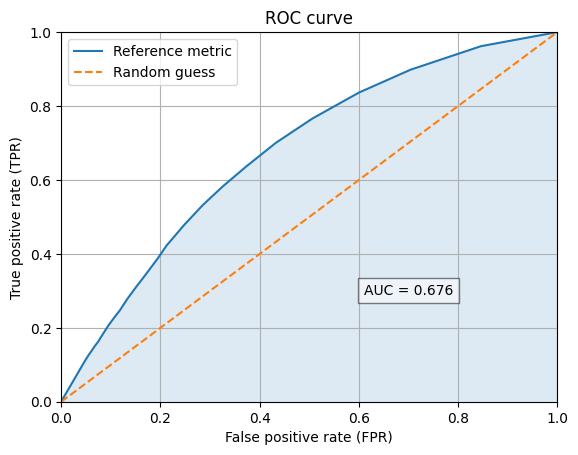

<Figure size 640x480 with 0 Axes>

In [20]:
ROCCurveReport.generate_report(
    metric_result=linear_itp_audit_results,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True,
    filename = logdir+'/_tmp/linear_itp_roc_curve.png'
)

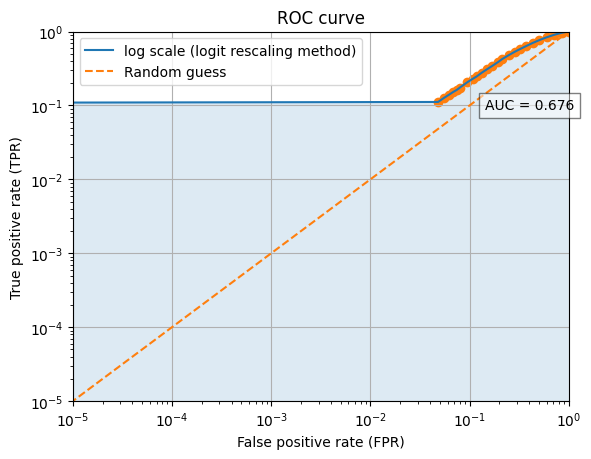

In [21]:
fpr = [mr.fp / (mr.fp + mr.tn) for mr in linear_itp_audit_results]
tpr = [mr.tp / (mr.tp + mr.fn) for mr in linear_itp_audit_results]
import pandas as pd
df = pd.DataFrame(data={
        'fpr': fpr,
        'tpr': tpr
    })
filepath = f"./{logdir}/_tmp/linear_itp_fpr_tpr_data.csv"
df.to_csv(filepath)
roc_auc = np.trapz(x=fpr, y=tpr)
range01 = np.linspace(0, 1)
import matplotlib.pyplot as plt
plt.fill_between(fpr, tpr, alpha=0.15)
plt.scatter(fpr, tpr)
plt.plot(fpr, tpr, label="log scale (logit rescaling method)")
plt.plot(range01, range01, '--', label='Random guess')
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**(-5), 1])
plt.ylim([10**(-5), 1])
plt.grid()
plt.legend()
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC curve')
plt.text(
            0.4, 0.1,
            f'AUC = {roc_auc:.03f}',
            horizontalalignment='center',
            verticalalignment='center',
            bbox=dict(facecolor='white', alpha=0.5)
        )
plt.savefig(logdir + "/_tmp/log_scale_linear_itp_roc_curve.png")

Then, we plot the audit results under attacks that use the logit rescaling method (which is a similar smoothing heuristic as Calini et. al. 2021) for smoothing the signal distribution and computing the threshold. We show both the TPR-FPR plot (original scale) and log-scale TPR-FPR plot

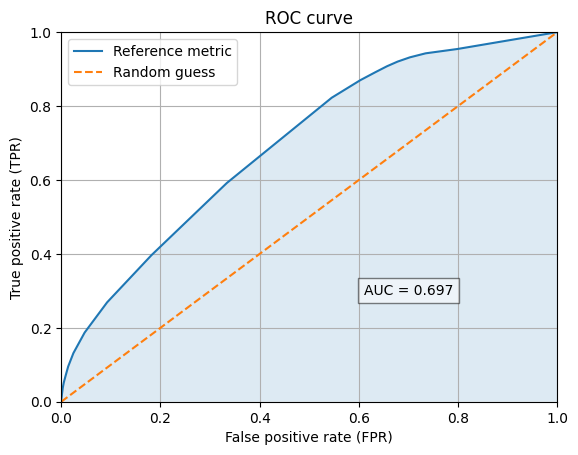

<Figure size 640x480 with 0 Axes>

In [22]:
ROCCurveReport.generate_report(
    metric_result=logit_rescale_audit_results,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True,
    filename = logdir+'/_tmp/logit_rescale_roc_curve.png'
)

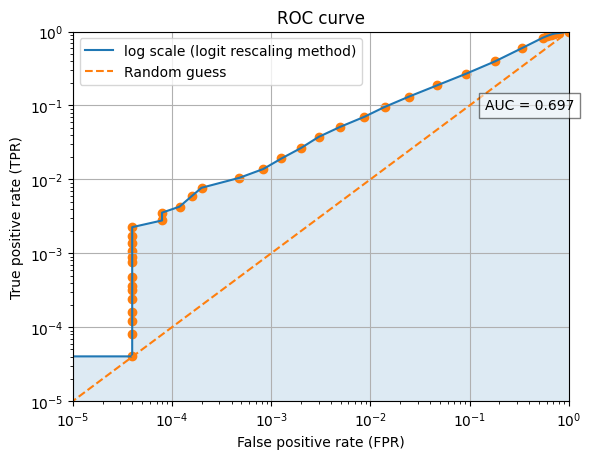

In [23]:
fpr = [mr.fp / (mr.fp + mr.tn) for mr in logit_rescale_audit_results]
tpr = [mr.tp / (mr.tp + mr.fn) for mr in logit_rescale_audit_results]
df = pd.DataFrame(data={
        'fpr': fpr,
        'tpr': tpr
    })
filepath = f"./{logdir}/_tmp/logit_rescale_fpr_tpr_data.csv"
df.to_csv(filepath)
roc_auc = np.trapz(x=fpr, y=tpr)
range01 = np.linspace(0, 1)
import matplotlib.pyplot as plt
plt.fill_between(fpr, tpr, alpha=0.15)
plt.scatter(fpr, tpr)
plt.plot(fpr, tpr, label="log scale (logit rescaling method)")
plt.plot(range01, range01, '--', label='Random guess')
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**(-5), 1])
plt.ylim([10**(-5), 1])
plt.grid()
plt.legend()
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC curve')
plt.text(
            0.4, 0.1,
            f'AUC = {roc_auc:.03f}',
            horizontalalignment='center',
            verticalalignment='center',
            bbox=dict(facecolor='white', alpha=0.5)
        )
plt.savefig(logdir + "/_tmp/log_scale_logit_rescale_roc_curve.png")

Finally, we the audit results under attacks that combines the linear interpolation and the logit rescaling method (which is a similar smoothing heuristic as Calini et. al. 2021) for smoothing the signal distribution and computing the threshold. More specifically, we use the minimum of the two threshold functions. We show both the TPR-FPR plot (original scale) and log-scale TPR-FPR plot

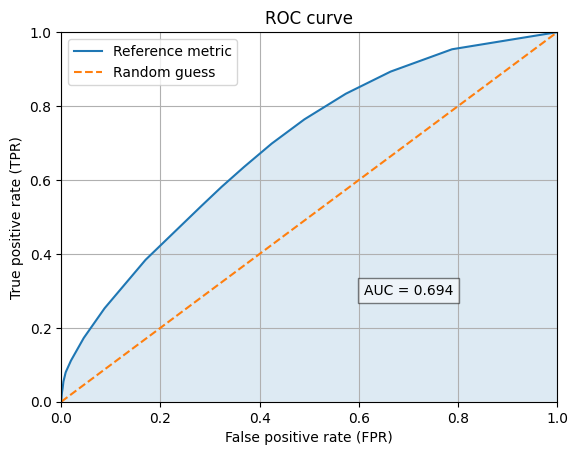

<Figure size 640x480 with 0 Axes>

In [24]:
ROCCurveReport.generate_report(
    metric_result=min_linear_logit_audit_results,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True,
    filename = logdir+'/_tmp/min_linear_logit_roc_curve.png'
)

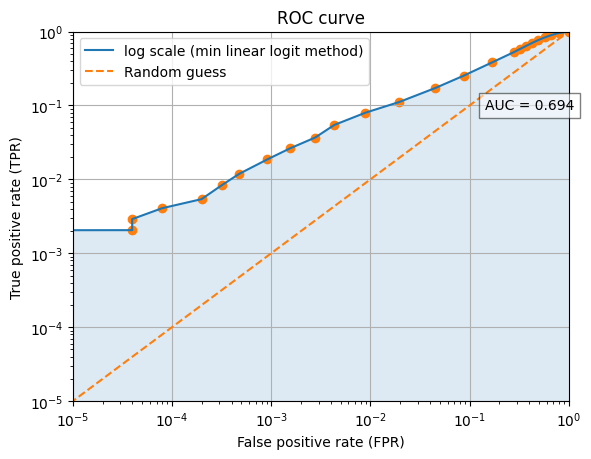

In [25]:
fpr = [mr.fp / (mr.fp + mr.tn) for mr in min_linear_logit_audit_results]
tpr = [mr.tp / (mr.tp + mr.fn) for mr in min_linear_logit_audit_results]
df = pd.DataFrame(data={
        'fpr': fpr,
        'tpr': tpr
    })
filepath = f"./{logdir}/_tmp/min_linear_logit_fpr_tpr_data.csv"
df.to_csv(filepath)
roc_auc = np.trapz(x=fpr, y=tpr)
range01 = np.linspace(0, 1)
import matplotlib.pyplot as plt
plt.fill_between(fpr, tpr, alpha=0.15)
plt.scatter(fpr, tpr)
plt.plot(fpr, tpr, label="log scale (min linear logit method)")
plt.plot(range01, range01, '--', label='Random guess')
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**(-5), 1])
plt.ylim([10**(-5), 1])
plt.grid()
plt.legend()
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC curve')
plt.text(
            0.4, 0.1,
            f'AUC = {roc_auc:.03f}',
            horizontalalignment='center',
            verticalalignment='center',
            bbox=dict(facecolor='white', alpha=0.5)
        )
plt.savefig(logdir + "/_tmp/log_scale_min_linear_logit_rescale_roc_curve.png")